In [1]:
!pip install -q transformers datasets scikit-learn evaluate accelerate
!pip install -q sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.7 MB/s eta 0:00:00


Roberta


In [ ]:
# === 1. IMPORTACIONES ===
import os
import re
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
from datasets import Dataset
import evaluate

# === 2. CARGA Y LIMPIEZA DE DATOS ===
df = pd.read_csv("TA1C_dataset_detection_train.csv", encoding="utf-8")

def limpieza_ligera(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+", "", texto)
    texto = re.sub(r"[^\w\s\"#]", "", texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

df["text"] = df["Teaser Text"].apply(limpieza_ligera)
df["label"] = df["Tag Value"].map({"Clickbait": 1, "No": 0})

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(),
    test_size=0.25, stratify=df["label"], random_state=0
)

# === 3. TOKENIZACIÓN Y MODELO ===
modelo_base = "PlanTL-GOB-ES/roberta-base-bne"
tokenizer = AutoTokenizer.from_pretrained(modelo_base)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)

def transform(example):
    return {
        "input_ids": torch.tensor(example["input_ids"]),
        "attention_mask": torch.tensor(example["attention_mask"]),
        "label": torch.tensor(example["label"]),
    }

train_tokenized.set_transform(transform)
val_tokenized.set_transform(transform)

model = AutoModelForSequenceClassification.from_pretrained(modelo_base, num_labels=2)

# === 4. ENTRENAMIENTO CON MÉTRICAS ===
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1_macro": f1_score(labels, predictions, average="macro"),
        "precision": precision.compute(predictions=predictions, references=labels, average="macro")["precision"],
        "recall": recall.compute(predictions=predictions, references=labels, average="macro")["recall"],
    }

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    report_to="none",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.00,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=100,
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics
)

trainer.train()

# === EVALUACIÓN COMPLETA DEL CONJUNTO DE VALIDACIÓN ===
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Predicción sobre el conjunto de desarrollo ===
val_preds = trainer.predict(val_tokenized)
val_pred_labels = np.argmax(val_preds.predictions, axis=-1)

# === Reporte de clasificación completo
report = classification_report(val_labels, val_pred_labels, target_names=["No", "Clickbait"], digits=4)
print("=== Classification Report sobre conjunto de desarrollo ===")
print(report)

# === Accuracy
acc = accuracy_score(val_labels, val_pred_labels)
print(f"\nAccuracy: {acc:.4f}")

# === Guardar reporte en archivo TXT
with open("classification_report_val.txt", "w", encoding="utf-8") as f:
    f.write("=== Classification Report (val set) ===\n")
    f.write(report)
    f.write(f"\nAccuracy: {acc:.4f}")

# === Matriz de confusión visual
cm = confusion_matrix(val_labels, val_pred_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Clickbait"], yticklabels=["No", "Clickbait"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

# === 6. PREDICCIÓN Y GENERACIÓN DE detection.csv ===
df_dev = pd.read_csv("TA1C_dataset_detection_dev.csv", encoding="utf-8")
df_dev["text"] = df_dev["Teaser Text"].apply(limpieza_ligera)
dev_dataset = Dataset.from_dict({"text": df_dev["text"].tolist()})
dev_tokenized = dev_dataset.map(tokenize_function, batched=True)

def transform_dev(example):
    return {
        "input_ids": torch.tensor(example["input_ids"]),
        "attention_mask": torch.tensor(example["attention_mask"]),
    }

dev_tokenized.set_transform(transform_dev)

predictions = trainer.predict(dev_tokenized)
pred_labels = np.argmax(predictions.predictions, axis=-1)
pred_tags = ["Clickbait" if label == 1 else "No" for label in pred_labels]

df_salida = pd.DataFrame({
    "Tweet ID": df_dev["Tweet ID"],
    "Tag Value": pred_tags
})
df_salida.to_csv("detection.csv", index=False, encoding="utf-8")
print("Archivo 'detection.csv' generado.")


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Berto

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Step,Training Loss
100,0.437800
200,0.279400
300,0.193600


=== Classification Report sobre conjunto de desarrollo ===
              precision    recall  f1-score   support

          No     0.8921    0.9242    0.9078       501
   Clickbait     0.7901    0.7186    0.7526       199

    accuracy                         0.8657       700
   macro avg     0.8411    0.8214    0.8302       700
weighted avg     0.8631    0.8657    0.8637       700


Accuracy: 0.8657


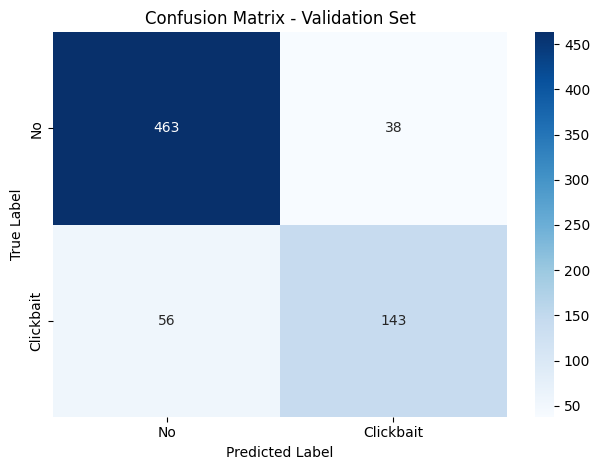


📝 Fila de la tabla:
LLM: dccuchile/bert-base-spanish-wwm-cased
LLM hyperparameters: lr=2e-5, batch_size=16, epochs=3, weight_decay=0.01


NameError: name 'eval_results' is not defined

In [3]:
# === ENTRENAMIENTO Y EVALUACIÓN DE UN LLM FINE-TUNED PARA DETECCIÓN DE CLICKBAIT ===

# === 1. IMPORTACIONES ===
import os
import re
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
from datasets import Dataset
import evaluate

# === 2. CARGA Y LIMPIEZA DE DATOS ===
df = pd.read_csv("TA1C_dataset_detection_train.csv", encoding="utf-8")

assert 'Teaser Text' in df.columns and 'Tag Value' in df.columns

def limpieza_ligera(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+", "", texto)
    texto = re.sub(r"[^\w\s\"#]", "", texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

# Aplicar limpieza
df["text"] = df["Teaser Text"].apply(limpieza_ligera)
df["label"] = df["Tag Value"].map({"Clickbait": 1, "No": 0})

# Dividir train/dev
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(),
    test_size=0.25, stratify=df["label"], random_state=0
)

# === 3. TOKENIZACIÓN Y MODELO ===
modelo_base = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(modelo_base)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)

# Usar set_transform para evitar conflicto con numpy 2.0
def transform(example):
    return {
        "input_ids": torch.tensor(example["input_ids"]),
        "attention_mask": torch.tensor(example["attention_mask"]),
        "label": torch.tensor(example["label"]),
    }
train_tokenized.set_transform(transform)
val_tokenized.set_transform(transform)

# Cargar modelo con salida para 2 clases
model = AutoModelForSequenceClassification.from_pretrained(modelo_base, num_labels=2)

# === 4. ENTRENAMIENTO CON METRICAS ===
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1_macro": f1_score(labels, predictions, average="macro"),
        "precision": precision.compute(predictions=predictions, references=labels, average="macro")["precision"],
        "recall": recall.compute(predictions=predictions, references=labels, average="macro")["recall"],
    }

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    report_to="none",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.00,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=100,
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics
)

# === ENTRENAR ===
trainer.train()
# === 5. EVALUACIÓN DETALLADA SOBRE EL VAL_DATASET ===
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Predicción sobre el conjunto de desarrollo ===
val_preds = trainer.predict(val_tokenized)
val_pred_labels = np.argmax(val_preds.predictions, axis=-1)

# === Reporte de clasificación completo
report = classification_report(val_labels, val_pred_labels, target_names=["No", "Clickbait"], digits=4)
print("=== Classification Report sobre conjunto de desarrollo ===")
print(report)

# === Accuracy
acc = accuracy_score(val_labels, val_pred_labels)
print(f"\nAccuracy: {acc:.4f}")

# === Guardar el reporte como archivo para el informe
with open("classification_report_val_bert.txt", "w", encoding="utf-8") as f:
    f.write("=== Classification Report (val set) ===\n")
    f.write(report)
    f.write(f"\nAccuracy: {acc:.4f}")

# === Matriz de confusión visual
cm = confusion_matrix(val_labels, val_pred_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Clickbait"], yticklabels=["No", "Clickbait"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

# EJEMPLO DE TABLA FINAL PARA EL REPORTE:
print("\n\U0001F4DD Fila de la tabla:")
print("LLM: dccuchile/bert-base-spanish-wwm-cased")
print("LLM hyperparameters: lr=2e-5, batch_size=16, epochs=3, weight_decay=0.01")
print(f"Average f-score macro: {eval_results['eval_f1_macro']:.4f}")
